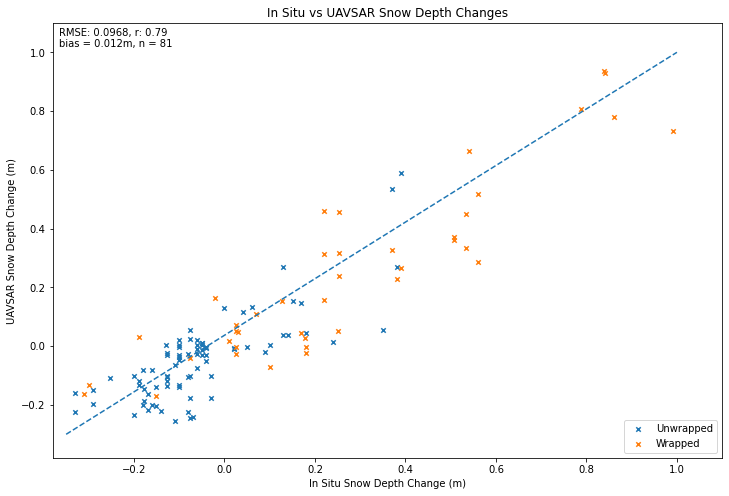

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from stats import get_stats
df_full = pd.read_parquet('/bsuhome/zacharykeskinen/uavsar-validation/data/insitu/insitu_uavsar_v2.parq').reset_index()

# Plot up all insitu against image

fig, ax = plt.subplots(1, figsize = (12,8))

img_type = 'unw'
band = 'VV'

sub = df_full.dropna(subset = [f'UV_unw_{band}_sd'])
wrapped = df_full.loc[df_full.index.difference(sub.index)]
df_full.plot.scatter(x = 'dSD', y = f'UV_{img_type}_{band}_sd', ax = ax, marker = 'x', color = f'C0', label = 'Unwrapped')
wrapped.plot.scatter(x = 'dSD', y = f'UV_int_{band}_sd', ax = ax, marker = 'x', color = f'C1', label = 'Wrapped')
rmse, r, n, bias = get_stats(sub.dSD.values.ravel(), sub[f'UV_{img_type}_{band}_sd'].values.ravel(), clean = True, bias = True)
ax.text(.01, .99, f'RMSE: {rmse:.3}, r: {r:.2}\nbias = {bias:.2}m, n = {n}', ha='left', va='top', transform=ax.transAxes)


ax.set_title('In Situ vs UAVSAR Snow Depth Changes')
ax.set_xlabel('In Situ Snow Depth Change (m)')
ax.set_ylabel('UAVSAR Snow Depth Change (m)')
ax.legend(loc = 'lower right')

ax.plot([-0.35, 1], [-0.3, 1], label = '1-to-1', linestyle = 'dashed')
ax.set_xlim(-0.38, 1.1)
ax.set_ylim(-0.38, 1.1)

plt.savefig('/bsuhome/zacharykeskinen/uavsar-validation/figures/insitu/insitu_all_v1.png')

In [83]:
n = 1000
img_type_label = {'int':'Wrapped', 'unw': 'Unwrapped'}
stats_res = pd.DataFrame(columns = ['rmse', 'r', 'bias'])
for i, band in enumerate(['VV', 'HV', 'VH','HH']):
    for j, img_type in enumerate(['int', 'unw']):
        sub = df_full.dropna(subset = ['UV_unw_VV_sd','UV_unw_VH_sd','UV_unw_HV_sd','UV_unw_HH_sd', 'dSD'])
        stats = {'rmse':np.zeros(n),'r': np.zeros(n),'bias' : np.zeros(n),'n':np.zeros(n)}
        for k in range(n):
            bs = sub.sample(len(sub), replace = True).copy()
            stats['rmse'][k], stats['r'][k],  stats['n'][k], stats['bias'][k] = get_stats(bs[f'UV_{img_type}_{band}_sd'], bs['dSD'], bias = True)
        for name, arr in stats.items():
            if name == 'n':
                continue
            stats_res.loc[f'{img_type_label[img_type]} {band}', name] = f'{np.quantile(arr, [0.05])[0]:.3} - {np.quantile(arr, [0.95])[0]:.3} [{np.mean(arr):.3}]'

print(f'N = {np.nanmean(stats["n"])}')
stats_res.to_csv('/bsuhome/zacharykeskinen/uavsar-validation/results/insitu/bootstrap_v3.csv')

N = 70.0


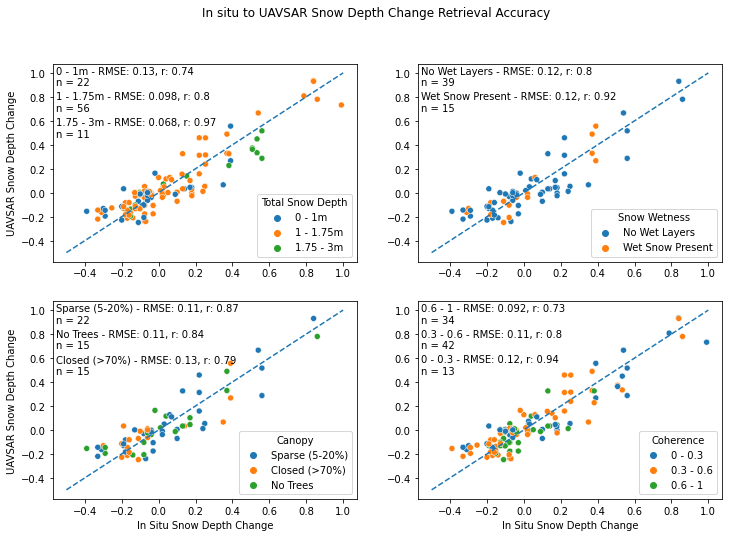

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from stats import get_stats

df_full = pd.read_parquet('/bsuhome/zacharykeskinen/uavsar-validation/data/insitu/insitu_uavsar_v2.parq')

import seaborn as sns
fig, axes = plt.subplots(2, 2, figsize = (12,8))

symbol_dic = {'NRCS':'o', 'SnowEx':'x'}

df = df_full.loc[df_full.datasource == 'SnowEx']

## SNOW DEPTH ##
df_full['sd_class'] = pd.cut(df_full.SD, [0, 1, 1.75, 3] )
sns.scatterplot(x = 'dSD', y = 'UV_int_VV_sd', hue = 'sd_class', data = df_full, ax = axes[0,0])

L=axes[0,0].legend()
L.get_texts()[0].set_text('0 - 1m')
L.get_texts()[1].set_text('1 - 1.75m')
L.get_texts()[2].set_text('1.75 - 3m')
sns.move_legend(axes[0,0], 'lower right', title = 'Total Snow Depth')

labels = {'(0.0, 1.0]':'0 - 1m', '(1.0, 1.75]':'1 - 1.75m', '(1.75, 3.0]':'1.75 - 3m'}
for i, c in enumerate(sorted(df_full.sd_class.unique())):
    name = labels[str(c)]
    rmse, r, n = get_stats(df_full[df_full.sd_class == c].dSD.values.ravel(), df_full[df_full.sd_class == c].UV_unw_VH_sd.values.ravel())
    axes[0,0].text(.01, .99 - i*0.13, f'{name} - RMSE: {rmse:.2}, r: {r:.2}\nn = {n}', ha='left', va='top', transform=axes[0,0].transAxes)

## SNOW WETNESS ##
sns.scatterplot(x = 'dSD', y = 'UV_int_VV_sd', hue = 'any_wet', data = df, ax = axes[0, 1])

L=axes[0,1].legend()
L.get_texts()[0].set_text('No Wet Layers')
L.get_texts()[1].set_text('Wet Snow Present')
sns.move_legend(axes[0,1], 'lower right', title = 'Snow Wetness')

labels = {0.0:'No Wet Layers', 1.0:'Wet Snow Present'}
for i, c in enumerate(df.any_wet.unique()):
    name = labels[c]
    rmse, r, n = get_stats(df[df.any_wet == c].dSD.values.ravel(), df[df.any_wet == c].UV_unw_VH_sd.values.ravel())
    axes[0, 1].text(.01, .99 - i*0.13, f'{name} - RMSE: {rmse:.2}, r: {r:.2}\nn = {n}', ha='left', va='top', transform=axes[0,1].transAxes)

## CANOPY ##
# remove open as n = 2
df = df[df.canopy != 'Open (20-70%)']
sns.scatterplot(x = 'dSD', y = 'UV_int_VV_sd', hue = 'canopy', data = df[df.canopy != 'Open (20-70%)'], ax = axes[1, 0])
sns.move_legend(axes[1, 0], title='Canopy', loc='lower right')

for i, c in enumerate(sorted(df[df.canopy != 'Open (20-70%)'].canopy.unique(), reverse = True)):
    rmse, r, n = get_stats(df[df.canopy == c].dSD.values.ravel(), df[df.canopy == c].UV_unw_VH_sd.values.ravel())
    axes[1, 0].text(.01, .99 - i*0.13, f'{c} - RMSE: {rmse:.2}, r: {r:.2}\nn = {n}', ha='left', va='top', transform=axes[1,0].transAxes)

## COHERENCE ##
df_full['cor_class'] = pd.cut(df_full.VV_cor, [0,0.35, 0.5, 1] )
sns.scatterplot(x = 'dSD', y = 'UV_int_VV_sd', hue = 'cor_class', data = df_full, ax = axes[1, 1])

L=axes[1,1].legend()
L.get_texts()[0].set_text('0 - 0.3')
L.get_texts()[1].set_text('0.3 - 0.6')
L.get_texts()[2].set_text('0.6 - 1')
sns.move_legend(axes[1,1], 'lower right', title = 'Coherence')

labels = {'(0.35, 0.5]':'0.3 - 0.6',
          '(0.5, 1.0]': '0.6 - 1',
          '(0.0, 0.35]': '0 - 0.3'}
for i, c in enumerate(sorted(df_full.cor_class.unique(), reverse=True)):
    name = labels[str(c)]
    rmse, r, n = get_stats(df_full[df_full.cor_class == c].dSD.values.ravel(), df_full[df_full.cor_class == c].UV_unw_VH_sd.values.ravel())
    axes[1, 1].text(.01, .99 - i*0.13, f'{name} - RMSE: {rmse:.2}, r: {r:.2}\nn = {n}', ha='left', va='top', transform = axes[1,1].transAxes)

for ax in axes.ravel():
    ax.plot([-0.5,1], [-0.5, 1], label = '1-to-1', linestyle = 'dashed')
    ax.set_xlabel('')
    ax.set_ylabel('')

for i, ax_r in enumerate(axes):
    for j, ax in enumerate(ax_r):
        if i == 1:
            ax.set_xlabel('In Situ Snow Depth Change')
        if j == 0:
            ax.set_ylabel('UAVSAR Snow Depth Change')

plt.suptitle('In situ to UAVSAR Snow Depth Change Retrieval Accuracy')
plt.savefig('/bsuhome/zacharykeskinen/uavsar-validation/figures/insitu/insitu_binned_scatter_v4.png')



/tmp/ipykernel_31241/1016193634.py:119: FutureWarning: The input object of type 'Bbox' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Bbox', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  bboxes = np.array(list(map(get_bbox, axes.flat)), mtrans.Bbox).reshape(axes.shape)


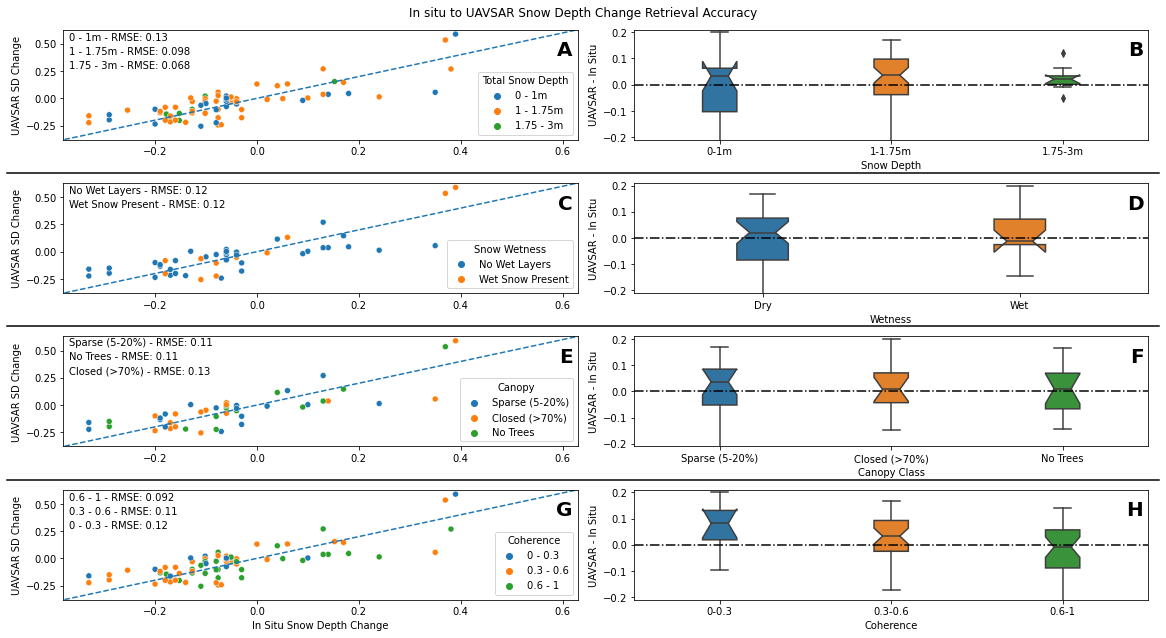

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from stats import get_stats

df_full = pd.read_parquet('/bsuhome/zacharykeskinen/uavsar-validation/data/insitu/insitu_uavsar_v2.parq')
df_full['diff'] = df_full['UV_unw_VV_sd'] - df_full['dSD']
import seaborn as sns
fig, axes = plt.subplots(4, 2, figsize = (16,9))

symbol_dic = {'NRCS':'o', 'SnowEx':'x'}

df = df_full.loc[df_full.datasource == 'SnowEx']

## SNOW DEPTH ##
df_full['sd_class'] = pd.cut(df_full.SD, [0, 1, 1.75, 3] )
sns.scatterplot(x = 'dSD', y = 'UV_unw_VV_sd', hue = 'sd_class', data = df_full, ax = axes[0,0])

L=axes[0,0].legend()
L.get_texts()[0].set_text('0 - 1m')
L.get_texts()[1].set_text('1 - 1.75m')
L.get_texts()[2].set_text('1.75 - 3m')
sns.move_legend(axes[0,0], 'lower right', title = 'Total Snow Depth')

labels = {'(0.0, 1.0]':'0 - 1m', '(1.0, 1.75]':'1 - 1.75m', '(1.75, 3.0]':'1.75 - 3m'}
for i, c in enumerate(sorted(df_full.sd_class.unique())):
    name = labels[str(c)]
    rmse, r, n = get_stats(df_full[df_full.sd_class == c].dSD.values.ravel(), df_full[df_full.sd_class == c].UV_unw_VH_sd.values.ravel())
    axes[0,0].text(.01, .98 - i*0.13, f'{name} - RMSE: {rmse:.2}', ha='left', va='top', transform=axes[0,0].transAxes)

ax2 = axes[0, 1]
sns.boxplot(data = df_full, x = 'sd_class', y = 'diff', ax = ax2, width = 0.2, notch = True)
ax2.set_xlabel('Snow Depth')
ax2.set_xticklabels(['0-1m', '1-1.75m', '1.75-3m'])

## SNOW WETNESS ##
ax1 = axes[1, 0]
sns.scatterplot(x = 'dSD', y = 'UV_unw_VV_sd', hue = 'any_wet', data = df, ax = ax1)

L=ax1.legend()
L.get_texts()[0].set_text('No Wet Layers')
L.get_texts()[1].set_text('Wet Snow Present')
sns.move_legend(axes[1, 0], 'lower right', title = 'Snow Wetness')

labels = {0.0:'No Wet Layers', 1.0:'Wet Snow Present'}
for i, c in enumerate(df.any_wet.unique()):
    name = labels[c]
    rmse, r, n = get_stats(df[df.any_wet == c].dSD.values.ravel(), df[df.any_wet == c].UV_unw_VH_sd.values.ravel())
    ax1.text(.01, .98 - i*0.13, f'{name} - RMSE: {rmse:.2}', ha='left', va='top', transform=ax1.transAxes)

ax2 = axes[1, 1]
sns.boxplot(data = df, x = 'any_wet', y = 'diff', ax = ax2, width = 0.2, notch = True)
ax2.set_xlabel('Wetness')
ax2.set_xticklabels(['Dry', 'Wet'])


## CANOPY ##
ax1 = axes[2, 0]
# remove open as n = 2
df = df[df.canopy != 'Open (20-70%)']
sns.scatterplot(x = 'dSD', y = 'UV_unw_VV_sd', hue = 'canopy', data = df[df.canopy != 'Open (20-70%)'], ax = ax1)
sns.move_legend(ax1, title='Canopy', loc='lower right')

for i, c in enumerate(sorted(df[df.canopy != 'Open (20-70%)'].canopy.unique(), reverse = True)):
    rmse, r, n = get_stats(df[df.canopy == c].dSD.values.ravel(), df[df.canopy == c].UV_unw_VH_sd.values.ravel())
    ax1.text(.01, .99 - i*0.13, f'{c} - RMSE: {rmse:.2}', ha='left', va='top', transform=ax1.transAxes)
ax2 = axes[2, 1]
sns.boxplot(data = df[df.canopy != 'Open (20-70%)'], x = 'canopy', y = 'diff', ax = ax2, width = 0.2, notch = True)
ax2.set_xlabel('Canopy Class')

## COHERENCE ##
ax1 = axes[3, 0]
df_full['cor_class'] = pd.cut(df_full.VV_cor, [0,0.35, 0.5, 1] )
sns.scatterplot(x = 'dSD', y = 'UV_unw_VV_sd', hue = 'cor_class', data = df_full, ax = ax1,)

L=ax1.legend()
L.get_texts()[0].set_text('0 - 0.3')
L.get_texts()[1].set_text('0.3 - 0.6')
L.get_texts()[2].set_text('0.6 - 1')
sns.move_legend(ax1, 'lower right', title = 'Coherence')

labels = {'(0.35, 0.5]':'0.3 - 0.6',
          '(0.5, 1.0]': '0.6 - 1',
          '(0.0, 0.35]': '0 - 0.3'}
for i, c in enumerate(sorted(df_full.cor_class.unique(), reverse=True)):
    name = labels[str(c)]
    rmse, r, n = get_stats(df_full[df_full.cor_class == c].dSD.values.ravel(), df_full[df_full.cor_class == c].UV_unw_VH_sd.values.ravel())
    ax1.text(.01, .98 - i*0.13, f'{name} - RMSE: {rmse:.2}', ha='left', va='top', transform = ax1.transAxes)

ax2 = axes[3, 1]
sns.boxplot(data = df_full, x = 'cor_class', y = 'diff', ax = ax2, width = 0.2, notch = True)
ax2.set_xlabel('Coherence')
ax2.set_xticklabels(['0-0.3', '0.3-0.6', '0.6-1'])

# broader fixes

for ax in axes[:, 1]:
    ax.set_ylabel('UAVSAR - In Situ')
    ax.set_ylim(-0.21, 0.21)
    ax.axhline(0, color = 'black', linestyle = 'dashdot')

for ax in axes[:, 0]:
    ax.plot([-0.5,1], [-0.5, 1], label = '1-to-1', linestyle = 'dashed')
    ax.set_xlabel('')
    ax.set_ylabel('')

for ax in axes[:, 0]:
    ax.set_ylabel('UAVSAR SD Change')

axes[-1, 0].set_xlabel('In Situ Snow Depth Change')
plt.suptitle('In situ to UAVSAR Snow Depth Change Retrieval Accuracy')

plt.tight_layout()

import matplotlib.transforms as mtrans
# Get the bounding boxes of the axes including text decorations
r = fig.canvas.get_renderer()
get_bbox = lambda ax: ax.get_tightbbox(r).transformed(fig.transFigure.inverted())
bboxes = np.array(list(map(get_bbox, axes.flat)), mtrans.Bbox).reshape(axes.shape)

#Get the minimum and maximum extent, get the coordinate half-way between those
ymax = np.array(list(map(lambda b: b.y1, bboxes.flat))).reshape(axes.shape).max(axis=1)
ymin = np.array(list(map(lambda b: b.y0, bboxes.flat))).reshape(axes.shape).min(axis=1)
ys = np.c_[ymax[1:], ymin[:-1]].mean(axis=1)

# Draw a horizontal lines at those coordinates
for y in ys:
    line = plt.Line2D([0,1],[y + 0.005, y + 0.005], transform=fig.transFigure, color="black", linestyle = '-')
    fig.add_artist(line)

for ax in axes[:, 0]:
    ax.set_xlim(-0.38, 0.63)
    ax.set_ylim(-0.38, 0.63)

ax_labs = {0:'A', 1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H',8:'I'}
for i, ax in enumerate(axes.ravel()):
    ax.text(.99, .9, ax_labs[i], ha = 'right', va = 'top', transform=ax.transAxes, fontweight = 'bold', fontsize = 20)

plt.savefig('/bsuhome/zacharykeskinen/uavsar-validation/figures/insitu/insitu_binned_v1.png')
